# 1

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
import json
import pybullet as p
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

NUM_VIEWS_PER_SCENE = 7


In [3]:

def visualize_segmentation(im, masks, nc=None):
    """ Visualize segmentations nicely. Based on code from:
        https://github.com/roytseng-tw/Detectron.pytorch/blob/master/lib/utils/vis.py

        @param im: a [H x W x 3] RGB image. numpy array of dtype np.uint8
        @param masks: a [H x W] numpy array of dtype np.uint8 with values in {0, ..., nc-1}
        @param nc: total number of colors. If None, this will be inferred by masks

        @return: a [H x W x 3] numpy array of dtype np.uint8
    """ 
    from matplotlib.patches import Polygon

    masks = masks.astype(int)
    im = im.copy()

    # Generate color mask
    if nc is None:
        NUM_COLORS = masks.max() + 1
    else:
        NUM_COLORS = nc

    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i/NUM_COLORS) for i in range(NUM_COLORS)]

    # Mask
    imgMask = np.zeros(im.shape)


    # Draw color masks
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Add to the mask
        imgMask[e] = color_mask

    # Add the mask to the image
    imgMask = (imgMask * 255).round().astype(np.uint8)
    im = cv2.addWeighted(im, 0.5, imgMask, 0.5, 0.0)


    # Draw mask contours
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Find contours
        contour, hier = cv2.findContours(
            e.astype(np.uint8).copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

        # Plot the nice outline
        for c in contour:
            cv2.drawContours(im, contour, -1, (255,255,255), 2)

    return im
    
### The two functions below were adatped from the DAVIS public dataset ###
def imread_indexed(filename):
    """ Load segmentation image (with palette) given filename."""
    im = Image.open(filename)
    annotation = np.array(im)
    return annotation

def imwrite_indexed(filename,array):
    """ Save indexed png with palette."""

    palette_abspath = '/home/chrisxie/projects/random_stuff/palette.txt' # hard-coded filepath
    color_palette = np.loadtxt(palette_abspath, dtype=np.uint8).reshape(-1,3)

    if np.atleast_3d(array).shape[2] != 1:
        raise Exception("Saving indexed PNGs requires 2D array.")

    im = Image.fromarray(array)
    im.putpalette(color_palette.ravel())
    im.save(filename, format='PNG')

def torch_to_numpy(torch_tensor, is_standardized_image = False):
    """ Converts torch tensor (NCHW) to numpy tensor (NHWC) for plotting
    
        If it's an rgb image, it puts it back in [0,255] range (and undoes ImageNet standardization)
    """
    np_tensor = torch_tensor.cpu().clone().detach().numpy()
    if np_tensor.ndim == 4: # NCHW
        np_tensor = np_tensor.transpose(0,2,3,1)
    if is_standardized_image:
        _mean=[0.485, 0.456, 0.406]; _std=[0.229, 0.224, 0.225]
        for i in range(3):
            np_tensor[...,i] *= _std[i]
            np_tensor[...,i] += _mean[i]
        np_tensor *= 255
            
    return np_tensor

def subplotter(images, titles=None, fig_num=1, plot_width=5):

    """ Function for plotting side-by-side images."""

    num_images = len(images)
    fig = plt.figure(fig_num, figsize=(num_images*plot_width, plot_width))

    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        if titles:
            plt.title(titles[i])

def array_to_tensor(array):
    """ Converts a numpy.ndarray (N x H x W x C) to a torch.FloatTensor of shape (N x C x H x W)
        OR
        converts a nump.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W)
    """

    if array.ndim == 4: # NHWC
        tensor = torch.from_numpy(array).permute(0,3,1,2).float()
    elif array.ndim == 3: # HWC
        tensor = torch.from_numpy(array).permute(2,0,1).float()
    else: # everything else
        tensor = torch.from_numpy(array).float()

    return tensor

def standardize_image(image):
    """ Convert a numpy.ndarray [H x W x 3] of images to [0,1] range, and then standardizes

        @return: a [H x W x 3] numpy array of np.float32
    """
    image_standardized = np.zeros_like(image).astype(np.float32)

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    for i in range(3):
        image_standardized[...,i] = (image[...,i]/255. - mean[i]) / std[i]

    return image_standardized

def worker_init_fn(worker_id):
    """ Use this to bypass issue with PyTorch dataloaders using deterministic RNG for Numpy
        https://github.com/pytorch/pytorch/issues/5059
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [131]:
BBOX = [0]*280000
class Tabletop_Object_Dataset(Dataset):
    def __init__(self, base_dir):
        self.base_dir = base_dir
        # Get a list of all scenes
        self.scene_dirs = sorted(glob.glob(self.base_dir + '*/'))
    
    def __len__(self):
        return len(self.scene_dirs) * NUM_VIEWS_PER_SCENE

    def process_rgb(self, rgb_img):
        """ Process RGB image
                - random color warping
        """
        rgb_img = rgb_img.astype(np.float32)
        rgb_img = standardize_image(rgb_img)

        return rgb_img

    def process_bbox(self, bbox, view_num):
        """ 
            The bounding box needs to be a list of points, 
            corresponding to the flattened coordinates of the top left point, 
            and bottom right point of the bounding box.
        """ 
        if view_num==1:
            return np.array([bbox])
        return np.array(bbox)

    def __getitem__(self, idx):

        cv2.setNumThreads(0) # some hack to make sure pyTorch doesn't deadlock. Found at https://github.com/pytorch/pytorch/issues/1355. Seems to work for me

        # Get scene directory
        scene_idx = idx // NUM_VIEWS_PER_SCENE
        scene_dir = self.scene_dirs[scene_idx]

        # Get view number
        view_num = idx % NUM_VIEWS_PER_SCENE

        # RGB image
        rgb_img_filename = scene_dir + f"rgb_{view_num:05d}.jpeg"
        rgb_img = cv2.cvtColor(cv2.imread(rgb_img_filename), cv2.COLOR_BGR2RGB)
        rgb_img = self.process_rgb(rgb_img)

        # Mask
        mask_filename = scene_dir + f"segmentation_{view_num:05d}.png"
        mask_img = imread_indexed(mask_filename)
        
        # Bounding Box
        bbox_filename = scene_dir + f"bbox_{view_num:05d}.txt"
        # bbox_points = [[]] if view_num==0 else np.loadtxt(bbox_filename) # (xmin, ymin, xmax, ymax)
        bbox_points = np.loadtxt(bbox_filename)
        bbox_points = self.process_bbox(bbox_points, view_num) # (xmin, ymin, xmax, ymax) 
        
        # Turn all into torch tensors
        # rgb_img = array_to_tensor(rgb_img)
        # mask_img = array_to_tensor(mask_img)
        # bbox_points = torch.from_numpy(bbox_points).float()
        
        # Save and return
        BBOX[idx]=bbox_points

        return {
                'rgb'  : rgb_img, 
                'mask' : mask_img,
            }

In [132]:
TOD_filepath = 'C:/dataset/TOD/' 
dataset = Tabletop_Object_Dataset(TOD_filepath + 'training_set/')
train_dataset = DataLoader(dataset=dataset, batch_size=4, shuffle=True)

In [154]:
for i in range(10):
    item = dataset.__getitem__(i)
    print(item['rgb'].shape, item['mask'].shape, BBOX[i].shape)

(480, 640, 3) (480, 640) (0,)
(480, 640, 3) (480, 640) (1, 4)
(480, 640, 3) (480, 640) (4, 4)
(480, 640, 3) (480, 640) (4, 4)
(480, 640, 3) (480, 640) (9, 4)
(480, 640, 3) (480, 640) (8, 4)
(480, 640, 3) (480, 640) (5, 4)
(480, 640, 3) (480, 640) (0,)
(480, 640, 3) (480, 640) (1, 4)
(480, 640, 3) (480, 640) (5, 4)


C:\Users\divya\AppData\Local\Temp\ipykernel_4272\1029570449.py:53: UserWarning: loadtxt: input contained no data: "C:/dataset/TOD/training_set\scene_00000\bbox_00000.txt"
  bbox_points = np.loadtxt(bbox_filename)
C:\Users\divya\AppData\Local\Temp\ipykernel_4272\1029570449.py:53: UserWarning: loadtxt: input contained no data: "C:/dataset/TOD/training_set\scene_00001\bbox_00000.txt"
  bbox_points = np.loadtxt(bbox_filename)


In [157]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_bbox_and_mask(rbg_img, bbox, mask_img):
     fig = plt.figure(figsize=(10, 10)) 
     
     fig.add_subplot(1, 2, 1) 
     plt.imshow(rbg_img)
     for box in bbox:
          show_box(box, plt.gca())
     plt.axis('on')
     plt.title("BBOX")

     fig.add_subplot(1, 2, 2) 
     plt.imshow(mask_img)
     plt.axis('on')
     plt.title("MASK")
     plt.show()

for i, sample in enumerate(train_dataset):
     print(sample['rgb'].shape, sample['mask'].shape)
     print(torch_to_numpy(sample['rgb']).shape, torch_to_numpy(sample['mask']).shape)
     print("--------")
     if i==10:
          break
     # show_bbox_and_mask(sample['rgb'], BBOX[i], sample['mask'])
     # fig = plt.figure(figsize=(10, 10)) 
     # fig.add_subplot(1, 2, 1) 
     # plt.imshow(sample['rgb'])
     # plt.axis('on')
     # plt.title("BBOX")
     # fig.add_subplot(1, 2, 2) 
     # plt.imshow(sample['mask'])
     # plt.axis('on')
     # plt.title("MASK")
     # plt.show()

C:\Users\divya\AppData\Local\Temp\ipykernel_4272\1029570449.py:53: UserWarning: loadtxt: input contained no data: "C:/dataset/TOD/training_set\scene_24783\bbox_00000.txt"
  bbox_points = np.loadtxt(bbox_filename)


torch.Size([4, 480, 640, 3]) torch.Size([4, 480, 640])
(4, 640, 3, 480) (4, 480, 640)
--------
torch.Size([4, 480, 640, 3]) torch.Size([4, 480, 640])
(4, 640, 3, 480) (4, 480, 640)
--------
torch.Size([4, 480, 640, 3]) torch.Size([4, 480, 640])
(4, 640, 3, 480) (4, 480, 640)
--------
torch.Size([4, 480, 640, 3]) torch.Size([4, 480, 640])
(4, 640, 3, 480) (4, 480, 640)
--------
torch.Size([4, 480, 640, 3]) torch.Size([4, 480, 640])
(4, 640, 3, 480) (4, 480, 640)
--------
torch.Size([4, 480, 640, 3]) torch.Size([4, 480, 640])
(4, 640, 3, 480) (4, 480, 640)
--------
torch.Size([4, 480, 640, 3]) torch.Size([4, 480, 640])
(4, 640, 3, 480) (4, 480, 640)
--------


C:\Users\divya\AppData\Local\Temp\ipykernel_4272\1029570449.py:53: UserWarning: loadtxt: input contained no data: "C:/dataset/TOD/training_set\scene_00985\bbox_00000.txt"
  bbox_points = np.loadtxt(bbox_filename)
C:\Users\divya\AppData\Local\Temp\ipykernel_4272\1029570449.py:53: UserWarning: loadtxt: input contained no data: "C:/dataset/TOD/training_set\scene_15335\bbox_00000.txt"
  bbox_points = np.loadtxt(bbox_filename)
C:\Users\divya\AppData\Local\Temp\ipykernel_4272\1029570449.py:53: UserWarning: loadtxt: input contained no data: "C:/dataset/TOD/training_set\scene_02299\bbox_00000.txt"
  bbox_points = np.loadtxt(bbox_filename)


torch.Size([4, 480, 640, 3]) torch.Size([4, 480, 640])
(4, 640, 3, 480) (4, 480, 640)
--------
torch.Size([4, 480, 640, 3]) torch.Size([4, 480, 640])
(4, 640, 3, 480) (4, 480, 640)
--------
torch.Size([4, 480, 640, 3]) torch.Size([4, 480, 640])
(4, 640, 3, 480) (4, 480, 640)
--------
torch.Size([4, 480, 640, 3]) torch.Size([4, 480, 640])
(4, 640, 3, 480) (4, 480, 640)
--------


C:\Users\divya\AppData\Local\Temp\ipykernel_4272\1029570449.py:53: UserWarning: loadtxt: input contained no data: "C:/dataset/TOD/training_set\scene_37797\bbox_00000.txt"
  bbox_points = np.loadtxt(bbox_filename)
C:\Users\divya\AppData\Local\Temp\ipykernel_4272\1029570449.py:53: UserWarning: loadtxt: input contained no data: "C:/dataset/TOD/training_set\scene_32134\bbox_00000.txt"
  bbox_points = np.loadtxt(bbox_filename)


C:\Users\divya\AppData\Local\Temp\ipykernel_4272\1029570449.py:53: UserWarning: loadtxt: input contained no data: "C:/dataset/TOD/training_set\scene_00000\bbox_00000.txt"
  bbox_points = np.loadtxt(bbox_filename)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


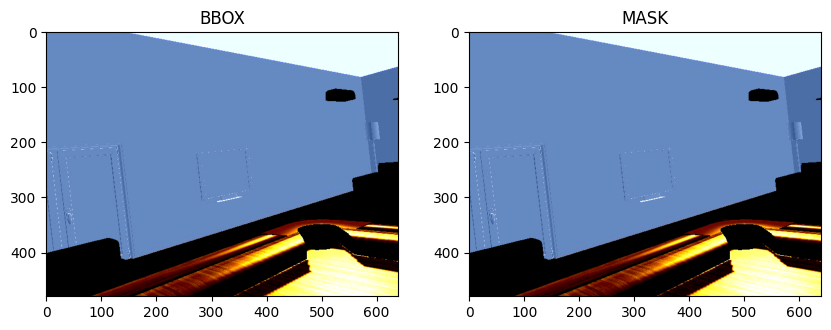

In [147]:
img = dataset.__getitem__(0)['rgb']
fig = plt.figure(figsize=(10, 10)) 
fig.add_subplot(1, 2, 1) 
plt.imshow(img)
plt.axis('on')
plt.title("BBOX")
fig.add_subplot(1, 2, 2) 
plt.imshow(img)
plt.axis('on')
plt.title("MASK")
plt.show()

# 2

In [ ]:
import glob
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from statistics import mean
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

NUM_VIEWS_PER_SCENE = 7

In [ ]:
TOD_filepath = 'C:/dataset/TOD/training_set/'
scenes_names = sorted(os.listdir(TOD_filepath))
scenes_paths = [TOD_filepath+j for j in scenes_names]

In [ ]:
# Visualization & Ploting Functions

def visualize_segmentation(im, masks, nc=None):
    """ Visualize segmentations nicely. Based on code from:
        https://github.com/roytseng-tw/Detectron.pytorch/blob/master/lib/utils/vis.py

        @param im: a [H x W x 3] RGB image. numpy array of dtype np.uint8
        @param masks: a [H x W] numpy array of dtype np.uint8 with values in {0, ..., nc-1}
        @param nc: total number of colors. If None, this will be inferred by masks

        @return: a [H x W x 3] numpy array of dtype np.uint8
    """ 
    from matplotlib.patches import Polygon

    masks = masks.astype(int)
    im = im.copy()

    # Generate color mask
    if nc is None:
        NUM_COLORS = masks.max() + 1
    else:
        NUM_COLORS = nc

    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i/NUM_COLORS) for i in range(NUM_COLORS)]

    # Mask
    imgMask = np.zeros(im.shape)


    # Draw color masks
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Add to the mask
        imgMask[e] = color_mask

    # Add the mask to the image
    imgMask = (imgMask * 255).round().astype(np.uint8)
    im = cv2.addWeighted(im, 0.5, imgMask, 0.5, 0.0)


    # Draw mask contours
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Find contours
        contour, hier = cv2.findContours(
            e.astype(np.uint8).copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

        # Plot the nice outline
        for c in contour:
            cv2.drawContours(im, contour, -1, (255,255,255), 2)

    return im

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_bbox_and_mask(rbg_img, bbox, mask_img, seg_img):
    fig = plt.figure(figsize=(10, 10)) 
    
    fig.add_subplot(1, 3, 1) 
    plt.imshow(rbg_img)
    for box in bbox:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.title("BBOX")

    fig.add_subplot(1, 3, 2) 
    plt.imshow(mask_img)
    plt.axis('on')
    plt.title("MASK")

    fig.add_subplot(1, 3, 3) 
    plt.imshow(seg_img)
    plt.axis('on')
    plt.title("Segmentation")
    plt.show()

In [ ]:
TRAINING_DATASET = [0]*70
# for i in tqdm(range(len(scenes_paths)*NUM_VIEWS_PER_SCENE)):
for i in tqdm(range(70)):
    scene_no=i//NUM_VIEWS_PER_SCENE
    scene_dir=scenes_paths[scene_no]
    view_num=i%NUM_VIEWS_PER_SCENE
    # RGB image
    rgb_img_filename = scene_dir + f"/rgb_{view_num:05d}.jpeg"
    rgb_img = cv2.cvtColor(cv2.imread(rgb_img_filename), cv2.COLOR_BGR2RGB)
    # Mask
    mask_filename = scene_dir + f"/segmentation_{view_num:05d}.png"
    im = Image.open(mask_filename)
    mask_img = np.array(im)
    # Bounding Box
    if view_num==0:
        bbox_points = np.array([])
    else: 
        bbox_filename = scene_dir + f"/bbox_{view_num:05d}.txt"
        if view_num==0:
            bbox_points = np.array([])
        else:
            bbox_points = np.loadtxt(bbox_filename)
            if view_num==1:                bbox_points=np.array([bbox_points])

    # seg_img=visualize_segmentation(rgb_img, mask_img)
    # show_bbox_and_mask(rgb_img, bbox_points, mask_img, seg_img)
    # if i==10:
    #     break
    TRAINING_DATASET[i] = {'rgb_img': rgb_img, 'mask_img': mask_img, 'bbox': bbox_points}

100%|██████████| 70/70 [00:00<00:00, 216.88it/s]


In [ ]:
# https://github.com/chrisdxie/uois/blob/master/src/data_loader.py

###### Some utilities #####
def standardize_image(image):
    """ Convert a numpy.ndarray [H x W x 3] of images to [0,1] range, and then standardizes

        @return: a [H x W x 3] numpy array of np.float32
    """
    image_standardized = np.zeros_like(image).astype(np.float32)

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    for i in range(3):
        image_standardized[...,i] = (image[...,i]/255. - mean[i]) / std[i]

    return image_standardized

def worker_init_fn(worker_id):
    """ Use this to bypass issue with PyTorch dataloaders using deterministic RNG for Numpy
        https://github.com/pytorch/pytorch/issues/5059
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)

def imread_indexed(filename):
    """ Load segmentation image (with palette) given filename."""
    im = Image.open(filename)
    annotation = np.array(im)
    return annotation

# def collate_fn(data):
#     rgb, mask, bbox = data
#     zipped = zip(rgb, mask, bbox)
#     return list(zipped)

def collate_fn(batch):
    return tuple(zip(*batch))

############# Synthetic Tabletop Object Dataset #############
class Tabletop_Object_Dataset(Dataset):
    """ Data loader for Tabletop Object Dataset
    """
    def __init__(self, base_dir):
        self.base_dir = base_dir
        # Get a list of all scenes
        self.scene_dirs = sorted(glob.glob(self.base_dir + '*/'))[:20]

    def __len__(self):
        return len(self.scene_dirs) * NUM_VIEWS_PER_SCENE

    def __getitem__(self, idx):

        cv2.setNumThreads(0) # some hack to make sure pyTorch doesn't deadlock. Found at https://github.com/pytorch/pytorch/issues/1355. Seems to work for me

        # Get scene directory
        scene_idx = idx // NUM_VIEWS_PER_SCENE
        scene_dir = self.scene_dirs[scene_idx]

        # Get view number
        view_num = idx % NUM_VIEWS_PER_SCENE

        # RGB image
        rgb_img_filename = scene_dir + f"rgb_{view_num:05d}.jpeg"
        rgb_img = cv2.cvtColor(cv2.imread(rgb_img_filename), cv2.COLOR_BGR2RGB)

        # Mask
        mask_filename = scene_dir + f"segmentation_{view_num:05d}.png"
        gt_mask_img = imread_indexed(mask_filename)

        # Bounding Box
        bbox_filename = scene_dir + f"bbox_{view_num:05d}.txt"
        if view_num==0:
            bbox_points=np.array([])
        else:
            bbox_points = np.loadtxt(bbox_filename) # (xmin, ymin, xmax, ymax)
            if view_num==1:
                bbox_points = np.array([bbox_points])
        # print(rgb_img.shape, gt_mask_img.shape, bbox_points.shape)

        # Turn these all into torch tensors and return
        return (torch.from_numpy(rgb_img).float(), torch.from_numpy(gt_mask_img).float(), torch.from_numpy(bbox_points).float())

In [ ]:
# dataset = Tabletop_Object_Dataset(TOD_filepath)
# dl = DataLoader(dataset=dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn(dataset), worker_init_fn=worker_init_fn)

In [ ]:
for sample in TRAINING_DATASET:
    print(f"{step}: {rgb.shape}, {gtmask.shape}, {boxes.shape}")

NameError: name 'step' is not defined